## Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit, Parameter, Parameters, Covariance


import warnings
from my_dataset_maps_19 import MapDatasetNuisance
warnings.filterwarnings('ignore')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



## Definitions 

In [2]:
def plot_residual_comparison(dataset1, dataset2, elist, radius = 1.0, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(len(elist)*1,3 ,figsize =(15,len(elist)*5))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][1],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][0],
                                                        vmax = vmax_, vmin = -vmax_)
        n, bins, patches = axs[i][2].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[i][2].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[i][2].legend(fontsize = 14)
        axs[i][2].set_xlabel('Significance'); axs[i][2].set_yscale('log')
        axs[i][1].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[i][0].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig

def plot_residual_comparison_vertical(dataset1, dataset2, elist, radius = 1.0, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(3, len(elist)*1 ,figsize =(len(elist)*5, 15))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[1][i],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[0][i],
                                                        vmax = vmax_, vmin = -vmax_)
        n, bins, patches = axs[2][i].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[2][i].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[2][i].legend(fontsize = 14)
        axs[2][i].set_xlabel('Significance'); axs[2][i].set_yscale('log')
        axs[1][i].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[0][i].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig




## Import of Datasets

In [3]:
source = "GC"

In [4]:
if source == "Crab":
    path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
    # here the dataset with the fine binning is saved
    #dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
    # This is for now the binning of 0.08 deg
    dataset_standard = MapDataset.read(f'{source}/stacked.fits')

    models = Models.read(f'{source}/standard_model.yml')

    with open(f'{source}/standard_bgmodel.yml', "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
    print(best_fit_bgmodel)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']


    models.append(bkg_model)
    dataset_standard.models = models
    dataset_standard.geoms['geom']



if source == "GC":
    path_GC ='/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_0.19'
    dataset_standard = MapDataset.read(f'{path_GC}/20220511_dataset002_hess1_muonflagTrue.fits')
    dataset_standard.stack(MapDataset.read(f'{path_GC}/20220511_dataset002_hess2_muonflagTrue.fits'))
    dataset_standard = dataset_standard.downsample(4)



    # Define source model for stacked fit
    from gammapy.modeling.models import (PointSpatialModel, 
                                         ExpCutoffPowerLawSpectralModel,
                                         PowerLawSpectralModel,
                                         GaussianSpatialModel)
    from regions import RectangleSkyRegion 
    spatial_model_center = PointSpatialModel(lon_0=359.9439608*u.deg, lat_0=-0.0418969*u.deg, frame='galactic') 
    spectral_model_center = ExpCutoffPowerLawSpectralModel(index=2.14, amplitude="2.55e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_='0.093 TeV-1')
    source_model_center = SkyModel(spatial_model=spatial_model_center, spectral_model=spectral_model_center, name="src")

    spatial_model_g09 = PointSpatialModel(lon_0=0.8717549*u.deg, lat_0=0.0767488*u.deg, frame='galactic')
    spectral_model_g09 = PowerLawSpectralModel(index=2.4, amplitude="0.838e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_g09 = SkyModel(spatial_model=spatial_model_g09, spectral_model=spectral_model_g09, name="g09")

    spatial_model_1745 = GaussianSpatialModel(lon_0=358.6435538*u.deg, lat_0=-0.5617789*u.deg, sigma=0.179*u.deg, frame='galactic')
    spectral_model_1745 = PowerLawSpectralModel(index=2.57, amplitude="1.73e-12 cm-2 s-1 TeV-1", reference="1 TeV") # 
    source_model_1745 = SkyModel(spatial_model=spatial_model_1745, spectral_model=spectral_model_1745, name="1745")

    spatial_model_1746 = PointSpatialModel(lon_0=0.1384563*u.deg, lat_0=-0.1112664*u.deg, frame='galactic')
    spectral_model_1746 = PowerLawSpectralModel(index=2.17, amplitude="0.18e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_1746 = SkyModel(spatial_model=spatial_model_1746, spectral_model=spectral_model_1746, name="1746")

    spatial_model_1746308 = GaussianSpatialModel(lon_0=358.4479799*u.deg, lat_0=-1.1140008*u.deg, sigma=0.162*u.deg, frame='galactic')
    spectral_model_1746308 = PowerLawSpectralModel(index=3.27, amplitude="0.70e-12 cm-2 s-1 TeV-1", reference="1 TeV") #
    source_model_1746308 = SkyModel(spatial_model=spatial_model_1746308, spectral_model=spectral_model_1746308, name="1746308")

    spatial_model_1741 = PointSpatialModel(lon_0=358.2753545*u.deg, lat_0=0.0515537*u.deg, frame='galactic')
    spectral_model_1741 = PowerLawSpectralModel(index=2.30, amplitude="0.21e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_1741 = SkyModel(spatial_model=spatial_model_1741, spectral_model=spectral_model_1741, name="1741")

    bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
    bkg_model.parameters['tilt'].frozen  = False

    models = Models([source_model_center, source_model_g09, source_model_1745, source_model_1746, 
                     source_model_1746308, source_model_1741, bkg_model ])
    
    
    j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')

    skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)
    geom_2d = dataset_standard.geoms['geom'].drop('energy')
    dataset_standard.mask_safe.data[:] &= Map.from_geom(geom_2d, 
                                                        data=geom_2d.region_mask([skyregion_1745], 
                                                                                          inside=False).data).data
    
    dataset_standard.models = models
    fit_standarad = Fit(store_trace=False)
    result_standarad = fit_standarad.run([dataset_standard])
    print(result_standarad)

Position <SkyCoord (Galactic): (l, b) in deg
    (88.08892708, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (88.08892708, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (271.79899452, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (271.79899452, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (8.75845743, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (8.75845743, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (351.12946417, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <Sk

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 3460
	total stat : -3260891.94

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 3460
	total stat : -3260891.94




In [11]:
added = '_008_25'
ebins = range(2,6)

path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
pathlocal = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/HESS_3Dbkg_syserror/2-error_in_dataset'
pathsource = f"{source}/"
dataset_N_10 = MapDatasetNuisance.read(f"{path}/{pathsource}nui_dataset{added}.fits")
with open(f'{pathsource}nui_par{added}.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
print(f'{pathlocal}/{pathsource}nui_model{added}.yml')
best_fit_model = Models.read(f'{pathlocal}/{pathsource}nui_model{added}.yml')

#with open(f'{pathlocal}/{pathsource}nui_model{added}.yml', "r") as ymlfile:
#    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(f'{pathsource}nui_bgmodel{added}.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
print(best_fit_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N_10.models =models
dataset_N_10.geoms['geom']

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/HESS_3Dbkg_syserror/2-error_in_dataset/GC/nui_model_008_25.yml


TypeError: 'NoneType' object is not subscriptable

In [ ]:
vmax = np.nanmax(np.abs(dataset_N_10.N_map().data))
dataset_N_10.N_map().plot_grid(add_cbar = True, vmax =vmax, vmin = -vmax);

1.6879330031324247


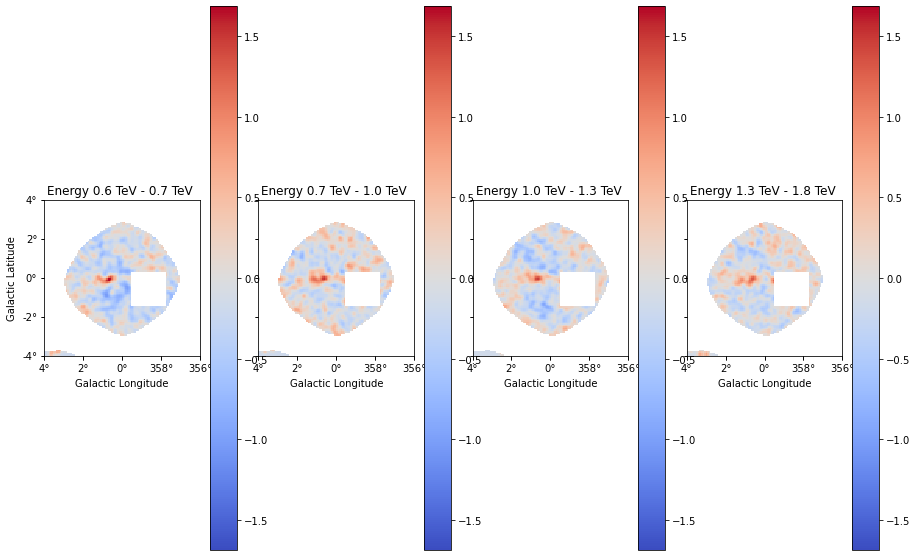

In [29]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6,10)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(np.nan_to_num(res_standard.data)))
print(vmax)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

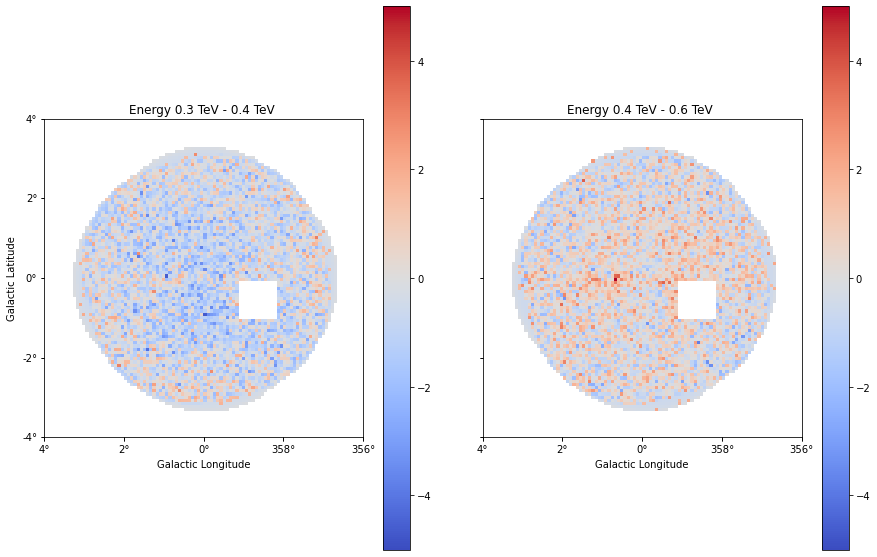

In [27]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.07 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[4:7])
result = estimator.run(dataset_standard)
ax = result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,ncols=4,figsize = (15,10));

Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


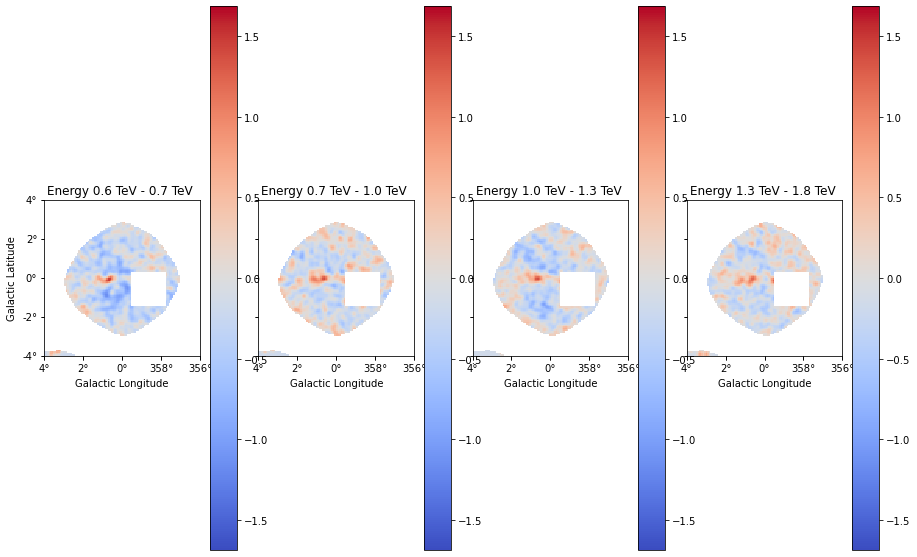

In [30]:
res_nui = (
    dataset_N_10.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6,10)))
    .smooth(0.1 * u.deg)
)
res_nui.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

## Comparison of the Spatial Resiudal Maps

Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


Radius: 0.1 deg
4
residual1.data: 5.773768009983256
vmax_: 1.8106764670561888


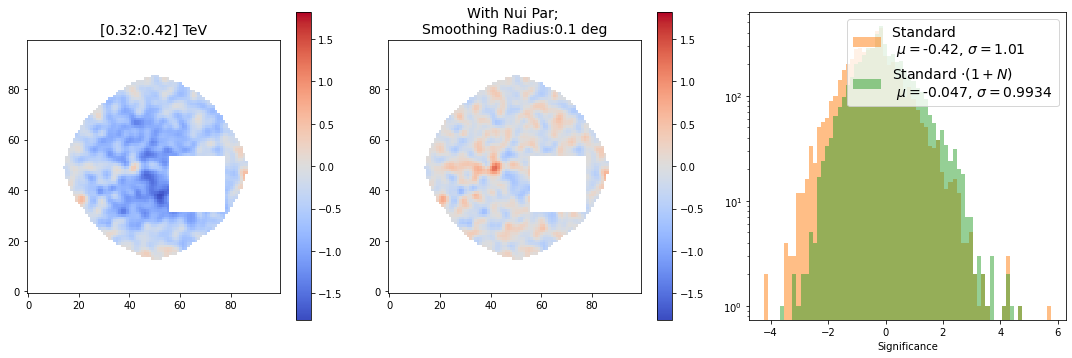

In [31]:
fig = plot_residual_comparison(dataset_standard, dataset_N_10,[4] , radius = 0.1 *u.deg)

Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


Radius: 0.1 deg
4


Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


residual1.data: 5.773768009983256
vmax_: 1.8106764670561888
5


Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


residual1.data: 7.725767762925504
vmax_: 2.033948182139281
6


Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


residual1.data: 6.075703865930631
vmax_: 1.6879330031324247
7


Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


residual1.data: 7.023064788792247
vmax_: 1.541318716970415


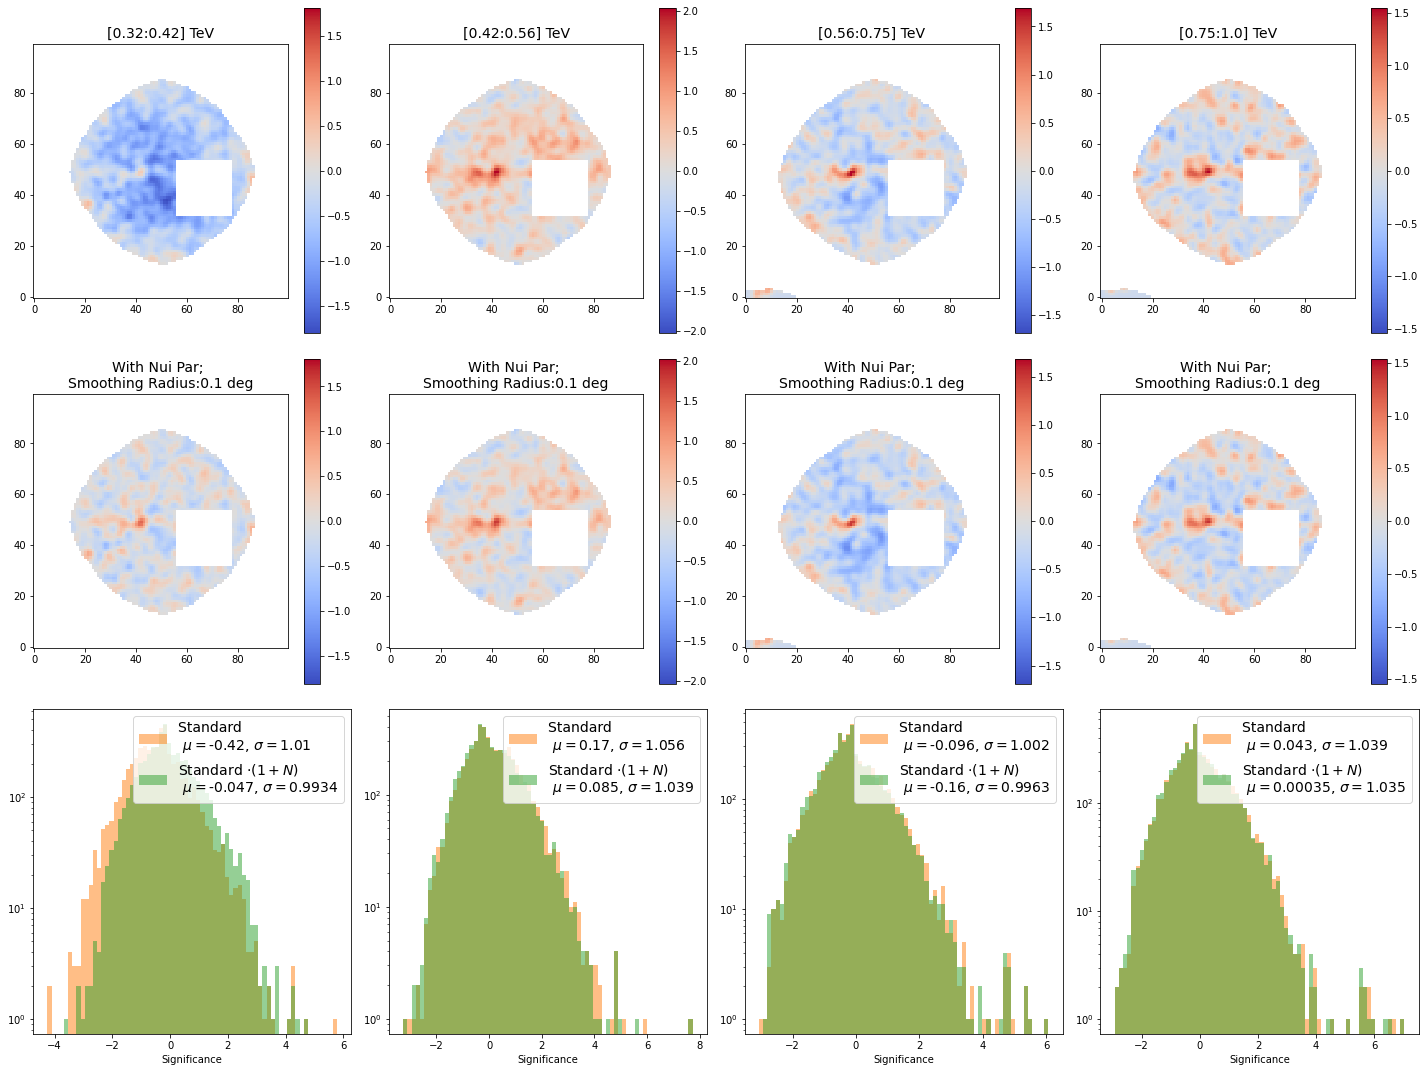

In [32]:

fig = plot_residual_comparison_vertical(dataset_standard, dataset_N_10,[4,5,6,7] , radius = 0.1 *u.deg)

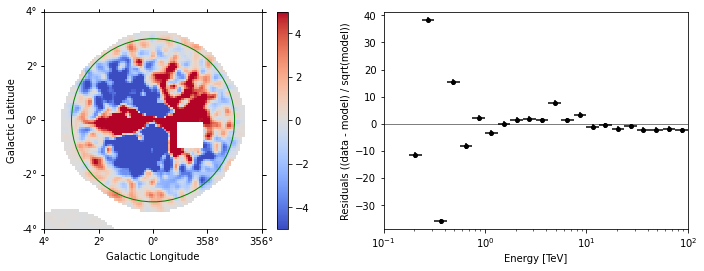

In [33]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.56742382, -66.14566675)> is outside valid IRF map range, using nearest IRF defined within


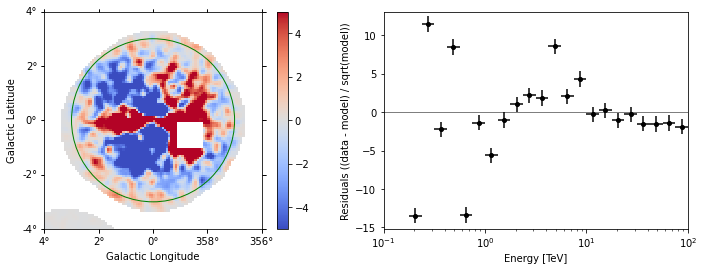

In [35]:
dataset_N_10.plot_residuals(kwargs_spectral=kwargs_spectral);

## Comparison of the Best Fit Model Parameters

In [36]:
print(" with nuisance")
print("(without nuisance)")
for p_N, p_stand in zip(dataset_N_10.models.parameters.free_parameters,
                        dataset_standard.models.parameters.free_parameters ):
    print()
    print('='*5)
    print(p_N.name, p_stand.name)
    print('-'*5)
    print(' {:.4}  pm {:.3}'.format(p_N.value, float(p_N.error)) )    
    print('({:.4}  pm {:.3})'.format(p_stand.value, float(p_stand.error)) )

print("nuisance: {:.4} std: {:.4}".format(np.mean(dataset_N_10.N_parameters.value)
                                   , np.std(dataset_N_10.N_parameters.value)))

 with nuisance
(without nuisance)

=====
index index
-----
 2.061  pm 0.00944
(2.054  pm 0.0335)

=====
amplitude amplitude
-----
 3.028e-12  pm 1.1e-14
(3.033e-12  pm 8.25e-14)

=====
lambda_ lambda_
-----
 0.1006  pm 0.00165
(0.1028  pm 0.0128)

=====
lon_0 lon_0
-----
 359.9  pm 3.61
(359.9  pm 0.00114)

=====
lat_0 lat_0
-----
 -0.04943  pm 0.000729
(-0.04949  pm 0.00111)

=====
index index
-----
 2.429  pm 0.0524
(2.429  pm 0.0404)

=====
amplitude amplitude
-----
 9.33e-13  pm 2.34e-15
(9.521e-13  pm 3.75e-14)

=====
lon_0 lon_0
-----
 0.8683  pm 0.00139
(0.8684  pm 0.00268)

=====
lat_0 lat_0
-----
 0.06531  pm 0.000112
(0.06528  pm 0.00265)

=====
index index
-----
 2.295  pm 0.0112
(2.303  pm 0.0276)

=====
amplitude amplitude
-----
 4.417e-12  pm 1.36e-14
(4.409e-12  pm 2.31e-13)

=====
lon_0 lon_0
-----
 359.9  pm 2.12
(359.9  pm 0.0277)

=====
lat_0 lat_0
-----
 -0.06232  pm 0.000512
(-0.06576  pm 0.0138)

=====
sigma sigma
-----
 0.3926  pm 0.00724
(0.3854  pm 0.0159)

===

In [37]:
sysamplitude_percentage = np.loadtxt((f'{path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100


In [38]:
len(default_colors*2)
default_colors = default_colors * 2

0 4
1 5
2 6


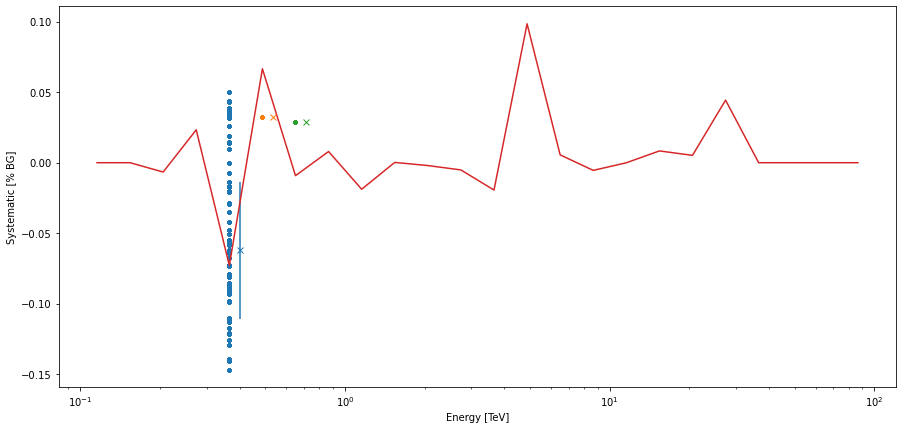

In [40]:
ebins = range(4,7)
fig = plt.figure(figsize = (15,7))
eaxis = dataset_N_10.geoms['geom'].axes[0].center.value
amount = dataset_N_10.geoms['geom_down'].data_shape[1]**2
mean_N_pars = []
max_N_pars = []
min_N_pars = []

bg_eaxis = dataset_N_10.background.data.sum(axis=2).sum(axis=1)
bg_down = dataset_N_10.background#.downsample(10,preserve_counts=True) 
bg_down_npred = dataset_N_10.npred_background()#.downsample(10,preserve_counts=True) 


for i, e in enumerate(ebins):
    print(i,e)
    data = ((bg_down_npred -bg_down  )/bg_down_npred).data[e,:,:].flatten()
    Ns = [d if np.abs(d)>0 else np.nan for d in data ]
    for N in Ns:
        plt.scatter(eaxis[e], [N], color = default_colors[i], s=10)
    plt.errorbar(x =eaxis[e]*1.1, y =  np.nanmean(Ns), yerr = np.nanstd(Ns), fmt='x')
plt.plot(eaxis,sysamplitude_percentage, label = "Expected Systematic") # * bg_eaxis
plt.ylabel('Systematic [% BG]')
plt.xlabel('Energy [TeV]')
plt.xscale('log')